# Data

Let's have a look at the data first

In [1]:
import os
from pathlib import Path

input_data_path = Path(os.environ.get('INPUT_DATA_PATH', '.'))
output_data_path = Path(os.environ.get('OUTPUT_DATA_PATH', '.'))

train_file = str(input_data_path / "data_train.npz")
test_file = str(input_data_path / "data_test.npz")
prediction_file = str(output_data_path / "data_test_prediction.npz")


if not (os.path.isfile(train_file) and
        os.path.isfile(test_file)):
    if not os.path.isfile("input_public_data.zip"):
        !wget https://codalab.coresearch.club/my/datasets/download/37304c34-1d4a-4f43-bcb2-1fdeb37c5cba -O input_public_data.zip
    !unzip -n input_public_data.zip

In [2]:
import numpy as np

In [3]:
data_real = np.load(train_file, allow_pickle=True)

# This is the calorimeter response:
energy = data_real['EnergyDeposit']

# These are the quantities we want to predict
momentum = data_real['ParticleMomentum'][:,:2]
coordinate = data_real['ParticlePoint'][:,:2]

In [4]:
print('energy.shape:', energy.shape)
print('momentum.shape:', momentum.shape)
print('coordinate.shape:', coordinate.shape)

energy.shape: (9916, 30, 30)
momentum.shape: (9916, 2)
coordinate.shape: (9916, 2)


So, we have images of 30x30 pixels and we want to predict 4 numbers for each of them: x, y, px and py.

Let's have a look at some of the images

In [5]:
import matplotlib.pyplot as plt

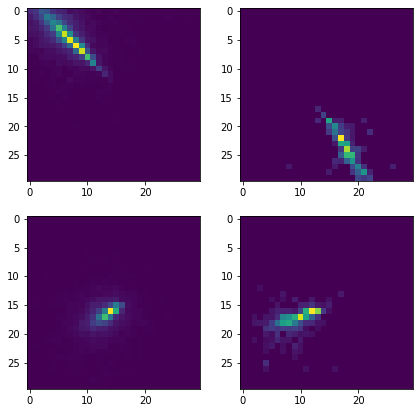

In [6]:
plt.figure(figsize=(7, 7))
plt.subplot(221)
plt.imshow(energy[2])
plt.subplot(222)
plt.imshow(energy[20])
plt.subplot(223)
plt.imshow(energy[200])
plt.subplot(224)
plt.imshow(energy[2000]);

It's also worth knowing how the targets are distributed:

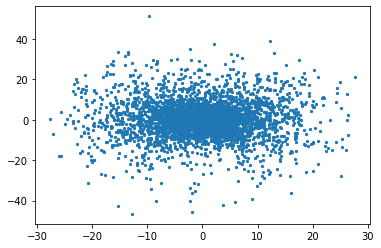

In [7]:
plt.scatter(*momentum.T, s=5);

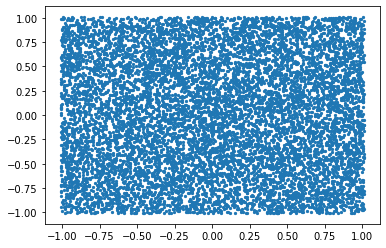

In [8]:
plt.scatter(*coordinate.T, s=5);

Naive approach: can we predict the coordinates from the center of mass position of the calorimeter response?

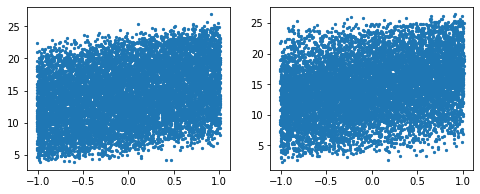

In [9]:
energy_density = energy / energy.sum(axis=(1, 2), keepdims=True)

cell_coords = np.stack([*np.meshgrid(
    np.arange(energy.shape[1]),
    np.arange(energy.shape[2])
)], axis=-1)[None,...]

center_of_mass = (energy_density[...,None] * cell_coords).sum(axis=(1, 2))

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(coordinate[:,0], center_of_mass[:,0], s=5)
plt.subplot(122)
plt.scatter(coordinate[:,1], center_of_mass[:,1], s=5);

Looks like the correlation isn't too strong. Maybe higher moments would give us a better picture, but we'll leave such experiments to you.

# Example solution

In [10]:
approaches = dict()

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim
import torchvision

from IPython.display import clear_output
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

In [12]:
X = energy[:,None,...] # adding Channels dimension
Y = np.concatenate([coordinate, momentum], axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(8924, 1, 30, 30) (8924, 4) (992, 1, 30, 30) (992, 4)


In [13]:
def make_torch_dataset(X, Y, batch_size, shuffle=True):
    X =torch.torch.tensor(X).float()
    #X[:,2:4] /= 40.
    Y = torch.tensor(Y).float()
    ds = utils.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        ds, batch_size=batch_size,
        pin_memory=True, shuffle=shuffle
    )

BATCH_SIZE = 1024

ds_train = make_torch_dataset(X_train, Y_train, BATCH_SIZE)
ds_val = make_torch_dataset(X_val, Y_val, BATCH_SIZE, shuffle=False)

#### Attention Modules
Attention is a concept from NLP, allowing e.g. a machine translation model to dynamically mask or up-weight
parts of an input sequence. It works great in NLP (c.f. Transformer).
Here we transfer this idea to (calorimeter-energy-deposit-)image processing, 
and allow the model to pick parts of channels, and channels, that it wants to focus on in a given example,
based on the features in the sample.

To make this concept useful, it is a good idea to give the model some freedom 
in computing the mask that determines the attention. 
The below model implements this by stacking fully connected dense layers to compute the key 
(we do not have a query, because the key already encapsulaates all directions along the image, unlike the seq-to-seq case).
But it may be even more useful to stack some convolutional layers when computing the key, 
as convolutions can do everything dense layers can, but are cheaper to optimize and store.

In [14]:
class Attention2d(nn.Module):
    """
    Straightforward attention using elementwise multiplication.
    """
    def __init__(self, n_channels = 1):
        super().__init__()
        # softmax the spatial dimensions of query 
        self.querynorm = nn.Softmax2d()
        # scale before softmax
        self.scale = nn.Parameter(torch.rand(n_channels))
        
        
    def forward(
                self,
                key,
                values):
        assert key.size() == values.size(),\
            f'shape mismatch between key (shape: {key.size()}) and values (shape: {values.size()})'

        ks = key.size()
        matchedscale = self.scale.unsqueeze(0).unsqueeze(2).unsqueeze(3).repeat(ks[0],1, ks[2], ks[3])
        mask = self.querynorm( key *  matchedscale)
        return values*mask
    
    
class AttBlock2d(nn.Module):
    """
    Attention calculating key using several dense layers.
    """
    
    def __init__(
            self, 
            image_shape, # 2d dim tuple
            n_channels, # image 'depth'
            latent_size = None, # size of intermediate state vectors passed between dense layers (default: image size)
            n_connected = 2): # number of dense layers 
        super().__init__()
        self.n_channels  = n_channels
        self.img_width, self.img_height = image_shape
        if latent_size is None:
            self.latent_size = self.flat_size
        else:
            self.latent_size = latent_size
        
        assert self.latent_size > 1, f'require at least 2 latent dimensions in between dense layers, got latent_size = {self.latent_size}'
        assert n_connected > 0, f'require at least 1 dense layer, got n_connected = {n_connected}' 
        
        dense_sizes = [[self.latent_size,self.latent_size] for _ in range(n_connected)]
        dense_sizes[0][0] = self.flat_size # so we always use full image, and can use view to match sizes
        dense_sizes[-1][1] = self.flat_size # so we can use view to resize into 2d image
        
        self.linear_layers = nn.ModuleList()
        for insize, outsize in dense_sizes:
            self.linear_layers.append(nn.Linear(insize, outsize))
        
        self.attention = Attention2d(self.n_channels)
        
    @property
    def flat_size(self):
        return self.n_channels * self.img_width * self.img_height
    
    def forward(self,x, key):
        
        key = self.get_dense_key(key)
        return self.attention(key, x)
        
    def get_dense_key(self,x):
        x = x.view(len(x), self.flat_size)
        for linear in self.linear_layers:
            x = F.relu(linear(x))
        x = x.view(len(x), self.n_channels, self.img_width, self.img_height)
        return x

In [15]:
class AttentiveConv2d(nn.Module):
    """
    Apply 2d convolution to  a values tensor and a keys tensor in tandem.
    
    Optionally, attention is applied to the input values, using a convolution of the keys.
    """
    def __init__(
            self, 
            in_channels, 
            out_channels, 
            kernel_size = 3, 
            activation = F.relu,
            final = False, # do _not_ compute & pass on a convolved key image
            attention = None): # attention arg. dict. Need to specifiy at least image_shape of inputs
        super().__init__()
        if kernel_size % 2 == 0:
            raise NotImplementedError(f'No support for even kernel sizes (got kernel_size={kernel_size})')
        conv_args = dict(
                in_channels = in_channels,
                out_channels = out_channels,
                kernel_size = kernel_size)
        self.valueConv = nn.Conv2d(**conv_args)
        self.activation = activation
        
        if final and attention is None:
            logging.warning(f'{type(self).__name__} with final == True and no attention is just a thin wrapper around torch.nn.Conv2d')
        
        if final:
            self.keyConv = None 
        else:
            self.keyConv = nn.Conv2d(**conv_args)
        
        if attention is not None:
            att_args = dict(
                    n_channels = in_channels)
            att_args.update(attention)
            self.attention = AttBlock2d(**att_args)
            conv_args['out_channels'] = in_channels
            conv_args['padding'] = (kernel_size - 1)//2 # padding such that image resolution is preserved
            self.keyConvForAtt = nn.Conv2d(**conv_args)
        else:
            self.attention = None
            self.keyConvForAtt = None
            

        
    def forward(self, value, key):
        if self.attention is not None:
            attkey = self.activation(self.keyConvForAtt(key))
            value = self.attention(value, attkey)
        
        value = self.activation(self.valueConv(value))
        
        if self.keyConv is None: # if final
            return value
        else:
            return value, self.activation(self.keyConv(key))

#### Two-component regressor
The momentum components and the impact coordinates have different units and different physical meaning.
It thus makes sense to compute them in two seperate regressors, concatenating in the end.
Thus each regressor is free to only focus on finding features relevant to its respective task.

Note that the input images are very sparse, and the showers only a few pixels wide. 
Thus we stick to kernels of size 3x3, with no stride or dilation being applied, 
to make the most of the shape information we do get.

##### Two-component regressor with momentum assistance
When we train this two component regressor, it turns out that momentum features are easy to learn well, 
but learning coordinates seems to be harder, taking much longer to converge. 

Suspecting that it may be beneficial to know the particle momentum (including travel direction) 
when trying to determine its impact point, we determine momentum first. 
Then we assist the coordinate regressor by making it aware of the particle momentum.
We also increase the number of channels pased between the first few layers, to accomodate the additional information.

This works well and increases the  effective convergence rate for particle impact coordinates
to be comparable to that of the momemntum components.
However, it seems there is still more work to be done on coordinate regression,
as the mean error on coordinates is still a bit larger than that on momenta.

(at first I tried using stacked dense layers to combine momentum- and coordinate information, but this 
pessimized the resulting MSE every time when compared to raw concatenated inputs)

#### Dropout layers
... to regularize the model during training, for more robust convergence. Helper functions make it easy to re-tune dropout after initial training. 

In [16]:
class ComponentPairRegressor(nn.Module):
    def __init__(self, dropout = 0.1, assisted = False):
        super().__init__()
        
        self.assisted = assisted
        
        self.conv1 = nn.Conv2d(
                in_channels=3 if self.assisted else 1,
                out_channels=5 if self.assisted else 3,
                kernel_size=3) # out: 30 -3 +1 = 28
        self.conv2 = nn.Conv2d(
                in_channels=5 if self.assisted else 3,
                out_channels=6 if self.assisted else 4,
                kernel_size=3) # out: 28 -3 +1 = 26 
        self.drop1 = nn.Dropout2d(p=dropout/24)
        
        self.conv3 = nn.Conv2d(
                in_channels=6 if self.assisted else 4 ,
                out_channels=7 if self.assisted else 5,
                kernel_size=3) # out: 26 -3 +1 = 24
        self.conv4 = nn.Conv2d(
                in_channels=7 if self.assisted else 5 ,
                out_channels=7 if self.assisted else 5,
                kernel_size=3) # out: 24 -3 +1 = 22
        self.conv5 = nn.Conv2d(
                in_channels=7 if self.assisted else 5 ,
                out_channels=8 if self.assisted else 6,
                kernel_size=3) # out: 22 -3 +1 = 20
        self.conv6 = nn.Conv2d(
                in_channels=8 if self.assisted else 6 ,
                out_channels=9 if self.assisted else 8,
                kernel_size=3) # out: 20 -3 +1 = 18
        self.drop2 = nn.Dropout2d(p=dropout/12)
        
        
        self.conv7 = nn.Conv2d(
                in_channels=9 if self.assisted else 8 ,
                out_channels=10 if self.assisted else 9,
                kernel_size=3) # out: 18 -3 +1 = 16
        self.conv8 = nn.Conv2d(
                in_channels=10 if self.assisted else 9 ,
                out_channels=11,
                kernel_size=3) # out:  16-3 +1 = 14
        self.conv9 = nn.Conv2d(
                in_channels=11 ,
                out_channels=12,
                kernel_size=3) # out:  14-3 +1 = 12
        self.conv10 = nn.Conv2d(
                in_channels=12,
                out_channels=13,
                kernel_size=3) # out: 12 -3 + 1 = 10
        self.drop3 = nn.Dropout2d(p=dropout/3)
        
        self.conv11 = AttentiveConv2d(
                in_channels = 13,
                out_channels = 14,
                kernel_size = 3) #  out: 10 - 3 + 1 = 8
        self.conv12 = AttentiveConv2d(
                in_channels = 14,
                out_channels = 14,
                kernel_size = 3) #  out: 8 - 3 + 1 = 6  
        self.conv13 = AttentiveConv2d(
                in_channels = 14,
                out_channels = 15,
                kernel_size = 3,
                final = True,
                attention = dict( 
                        image_shape = (6,6),  
                        n_connected = 4)) #  out: 6 - 3 + 1 = 4
        
        self.drop4 = nn.Dropout(p = dropout)
        self.fc1 = nn.Linear(4 * 4 * 15, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.drop1(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.drop2(x)
        
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.drop3(x)
        
        x, k = self.conv11(x, x)
        x, k = self.conv12(x, k)
        x = self.conv13(x, k)

        x = x.view(len(x), -1)
        x = self.drop4(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

    def set_dropout(self, p):
        for i in range(1,5):
            dl = getattr(self, f'drop{i}')
            if i == 1:
                fct = 24
            elif i == 2:
                fct = 12
            elif i == 3:
                fct = 3
            else:
                fct = 1
            dl.p = p/fct
    
class Regressor(nn.Module):
    def __init__(self, dropout = 0.5):
        super().__init__()
        self.coordinate_regressor = ComponentPairRegressor(assisted = True, dropout = dropout) 
        self.momentum_regressor = ComponentPairRegressor(dropout = dropout)
        
    def set_dropout(self, p):
        self.coordinate_regressor.set_dropout(p)
        self.momentum_regressor.set_dropout(p)
        
    def forward(self, x):
        momentum  = self.momentum_regressor(x)
        if self.coordinate_regressor.assisted:
            assistance = momentum.unsqueeze(2)
            assistance.unsqueeze_(3) # in-place
            assistance = assistance.expand(-1, -1, x.size()[2], x.size()[3])
            x = torch.cat((x,assistance), dim = 1)
        coordinate  = self.coordinate_regressor(x)
        x =  torch.cat((coordinate, momentum), dim = 1)
        
        return x
        
        

In [17]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [18]:
regressor = Regressor().to(device)

#### Learning rate decay

Reducing the learning rate as the training progresses allows the model to better tease out small performance gains near the minimum.

In [19]:
learning_rate = 3e-3
decay_rate = 0.99

opt = optim.Adam(regressor.parameters(),  lr=learning_rate )
lr_sched = optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=decay_rate)

In [20]:
def metric_relative_mse(y_true, y_pred):
    return (
        (y_true - y_pred).pow(2).mean(dim=0) / y_true.pow(2).mean(dim=0)
    )

def metric_relative_mse_total(y_true, y_pred):
    return metric_relative_mse(y_true, y_pred).sum()

In [21]:
# Disclaimer: this might not be the best loss function for this task.

class RelMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss(reduction = 'none')
    def forward(self, true, pred):
        per_comp = self.mse(true, pred).mean(dim =0) / true.pow(2).mean(dim =0)
        return (per_comp[0:2] + 100*per_comp[2:4]).sum()
        
        
loss_fn = RelMSELoss().to(device)

In [22]:
losses_train = []
losses_val = []
metrics_train = []
metrics_val = []
per_component_metrics_train = []
per_intcomp_metrics_train = []
per_component_metrics_val = []
per_intcomp_metrics_val = []

#### Stepwise exponential dropout decay
Like high learning rate, too high dropout hinders the final, precise convergence into shallow minima.
Exponentially decaying dropout can avoid this issue, but dropout should be kept constant over many epochs to
allow the model to learn robustness against dropout of activations. Stepwise exponential decay accomodates both constraints. 

In [23]:
class DropoutScheduler:
    """
    Scheduler class for managing decay of dropout over course of training. 
    """
    def __init__(self, initial = 0.1, decay_factor= 0.3, every = 50):
        self.initial_dropout = initial
        self.decay_factor = decay_factor
        self.epoch = 0
        self.every = every
    
    def step(self):
        self.epoch += 1
        return (self.epoch-1) % self.every == 0
    
    @property
    def dropout(self):
        return self.initial_dropout * (self.decay_factor**(self.epoch//self.every) )

In [24]:
def freeze_weights(model,flipped = False):
    for p in model.parameters():
        p.requires_grad = flipped

def  unfreeze_weights(model):
    freeze_weights(model, flipped = True)

do_sched = DropoutScheduler()
def run_training(epochs=50):

    
    for epoch in tqdm(range(epochs)):
        for batch_X, batch_Y in ds_train:
                batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            
                pred = regressor(batch_X)
                loss = loss_fn(batch_Y, pred)

                opt.zero_grad()
                loss.backward()
                opt.step()

                losses_train.append(loss.item())
                metrics_train.append(
                    metric_relative_mse_total(batch_Y, pred).item()
                )

                per_component_metrics_train.append(
                    metric_relative_mse(batch_Y, pred).detach().cpu().numpy()
                )

        lr_sched.step()
        
        if do_sched.step():
            regressor.set_dropout(do_sched.dropout)
            
        
        avg_loss, avg_metrics, avg_per_component_metrics = [], [], []
        regressor.eval()
        for batch_X, batch_Y in ds_val:
                batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
                pred = regressor(batch_X)
                loss = loss_fn(batch_Y, pred)

                avg_loss.append(loss.item())
                avg_metrics.append(
                    metric_relative_mse_total(batch_Y, pred).item()
                )
                avg_per_component_metrics.append(
                    metric_relative_mse(batch_Y, pred).detach().cpu().numpy())
        regressor.train()           
        losses_val.append(np.mean(avg_loss))
        metrics_val.append(np.mean(avg_metrics))
        per_component_metrics_val.append(
            np.mean(avg_per_component_metrics, axis=0)
        )
        

def plot_training(yscale = 'log'):
        
    
        plt.figure(figsize=(18, 4.5))

        plt.subplot(131)

        plt.title("Loss")
        plt.plot(losses_train, label='train')
        plt.plot(
            np.linspace(0, len(losses_train), len(losses_val), endpoint=False),
            losses_val, label='val'
        )
        plt.legend()
        plt.gca().set_yscale(yscale)
        plt.subplot(132)

        plt.title("Metric (per component)")
        ms_train = np.array(per_component_metrics_train).T
        ms_val = np.array(per_component_metrics_val).T
        for i, (m_train, m_val, color) in enumerate(zip(ms_train,
                                                        ms_val,
                                                        plt.rcParams['axes.prop_cycle'])):
            plt.plot(m_train, label=f'train (component {i})', c=color['color'])
            plt.plot(
                np.linspace(0, len(m_train), len(m_val), endpoint=False),
                m_val, '--', label=f'val (component {i})', c=color['color']
            )
        plt.legend()
        
        
        plt.subplot(133)

        plt.title("Metric (total)")
        plt.plot(metrics_train, label='train')
        plt.plot(
            np.linspace(0, len(metrics_train), len(metrics_val), endpoint=False),
            metrics_val, label='val'
        )
        plt.gca().set_yscale(yscale)
        plt.legend()
        plt.show()

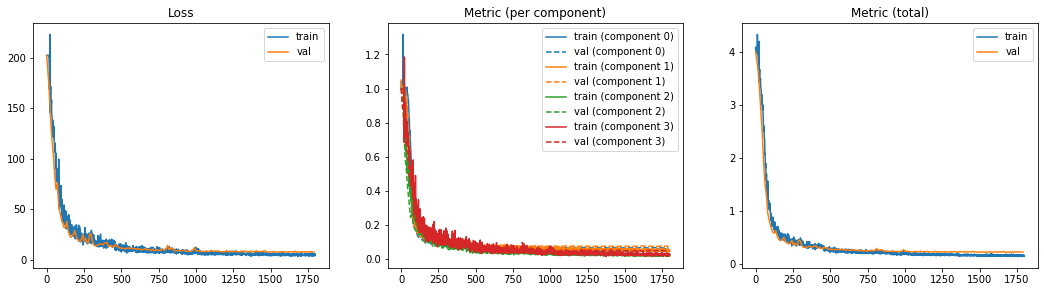

0.22172066271305085


In [25]:
for _ in range(20): 
    run_training(10)
    clear_output()
    plot_training('linear')
    print(np.mean(metrics_val[-5:]))

In [32]:
mymean = np.mean(metrics_val[-100:])
print(mymean)

approaches['no pooling, all kernels size 3, fewer channels, simple attn, exp. decay LR @0.99 from 3e-3, DO decay from 0.1 by 0.3 @ 50'] = mymean
# next: 'no pooling, all kernels size 3, fewer channels, final conv. attn, exp. decay LR @0.99 from 3e-3, DO decay from 0.1 by 0.3 @ 50'
from pprint import pprint
pprint(approaches)

0.2257415920495987
{'no pooling, all kernels size 3, fewer channels, simple attn, exp. decay LR @0.99 from 3e-3, DO decay from 0.1 by 0.3 @ 50': 0.2257415920495987}


## Current Working Hypothesis

The models converge quickly, then start to overtrain , but the validation error stays flat.
So perhaps the limit is model capacity, and more layers will help?

**ideas**
* multiple attention steps, throughout the latter regressor stack
* attention being applied to previous inputs?

In [27]:
data_test = np.load(test_file, allow_pickle=True)
X_test = data_test['EnergyDeposit'][:,None,...]

In [28]:
regressor.eval()
regressor.cpu()
prediction_test = regressor(torch.tensor(X_test, device='cpu').float()).cpu()
regressor.train()

Regressor(
  (coordinate_regressor): ComponentPairRegressor(
    (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(5, 6, kernel_size=(3, 3), stride=(1, 1))
    (drop1): Dropout2d(p=0.00011249999999999998, inplace=False)
    (conv3): Conv2d(6, 7, kernel_size=(3, 3), stride=(1, 1))
    (conv4): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
    (conv5): Conv2d(7, 8, kernel_size=(3, 3), stride=(1, 1))
    (conv6): Conv2d(8, 9, kernel_size=(3, 3), stride=(1, 1))
    (drop2): Dropout2d(p=0.00022499999999999997, inplace=False)
    (conv7): Conv2d(9, 10, kernel_size=(3, 3), stride=(1, 1))
    (conv8): Conv2d(10, 11, kernel_size=(3, 3), stride=(1, 1))
    (conv9): Conv2d(11, 12, kernel_size=(3, 3), stride=(1, 1))
    (conv10): Conv2d(12, 13, kernel_size=(3, 3), stride=(1, 1))
    (drop3): Dropout2d(p=0.0008999999999999999, inplace=False)
    (conv11): AttentiveConv2d(
      (valueConv): Conv2d(13, 14, kernel_size=(3, 3), stride=(1, 1))
      (keyConv): Conv2d(13, 14

In [29]:
coordinate_test, momentum_test = (
    prediction_test.detach().numpy()[:, :2],
    prediction_test.detach().numpy()[:, 2:],
)

In [30]:
np.savez_compressed(prediction_file,
                    ParticlePoint=coordinate_test,
                    ParticleMomentum=momentum_test)

In [31]:
def scoring_function(solution_file, predict_file):
    score = 0.
    
    solution = np.load(solution_file, allow_pickle=True)
    predict = np.load(predict_file, allow_pickle=True)
    ParticleMomentum_sol = solution['ParticleMomentum'][:, :2]
    ParticlePoint_sol = solution['ParticlePoint'][:, :2]
    
    ParticleMomentum_pred = predict['ParticleMomentum'][:, :2]
    ParticlePoint_pred = predict['ParticlePoint'][:, :2]
    
    score += np.sum(np.square(ParticleMomentum_sol - ParticleMomentum_pred).mean(axis=0) / np.square(ParticleMomentum_sol).mean(axis=0))
    score += np.sum(np.square(ParticlePoint_sol - ParticlePoint_pred).mean(axis=0) / np.square(ParticlePoint_sol).mean(axis=0))
    return score